# Michelle Helfman Term Project Milestone 2

# Moving Starter Kit

The Moving Starter Kit is basic demographic, economic, education, and 
additional location-based information to be used as a starting point to 
finding a new city to live or confirm the current location is the best 
place to be.

In [1]:
# Import Functions

import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import difflib
import os

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set your custom color palette

colors = ["#FF0B04", "#4374B3"]
hue_order = ['Metro Area', 'Micro Area']
sns.set_palette(sns.color_palette(colors))
red = "#FF0B04"
blue = "#4374B3"
purple = "#782F98"
green = "#00CC66"

In [3]:
# Read in the Moving Starter Kit and addition crime statistics
# Delete the existing output file.

# Read in spreadsheets
try:
# Moving Starter Kit
    MSK_df = pd.read_excel("Moving Starter Kit Flat File.xlsx")
    
except IOError as e:
    print("An Error Occurred Reading The Moving Stalert Kit file: ", e)

try:
# Additional Crime Information
    metro_crime_df = pd.read_excel("Additional_Crime_Stats.xlsx")
    
except IOError as er:
    print("An Error Occurred Reading the Addtional Crine Statistics: ", er)

# Delete the existing output file.
file = 'MSK Milestone 2.xlsx'
location = "C:/DSC540_Data/"
path = os.path.join(location, file)
 
# Remove the file
try:
    os.remove(path)
    
except:
    print('No Prior File Deleted')


## Cleanup, Format, and Add Missing Information to the Moving Starter Kit data

## Step 1 Replace the column headers with a more readable format

In [4]:
# Rename the column headers for more standardization.
# See MSK Milestone 2.xlsx for the complete list of new column headers.

new_col_headers = {'metro_area': 'Metropolitan_Area', 
'metro_short': 'Metropolitan_Short', 
'state': 'State', 'state_code': 'State_Code', 
'total_population': 'Total_Population', 
'anchor_city': 'Anchor_City', 
'anchor_population': 'Anchor_City_Population', 'median_age': 'Median_Age', 
'male_pct': 'Male_PCT', 'female_pct': 'Female_PCT','white_pct': 'White_PCT', 
'black_pct': 'Black_PCT', 'asian_pct': 'Asian_PCT', 'latino_pct': 'Latino_PCT', 
'american_indian_alaska_native_pct': 'American_Indian_Alaska_Native_PCT', 
'pacific_islander_pct': 'Pacific_Islander_PCT', 'mean_income': 'Mean_Income', 
'employment_pct': 'Employment_PCT', 
'high_school_grad_rate': 'High_School_Grad_Rate', 
'college_degree_pct': 'College_Degree_PCT',
'education_rank_state': 'Education_State_Ranking', 
'education_quality_rank_state': 'Education_Quality_State_Ranking', 
'airports': 'Number_of_Airports', 'income_tax_rate_low': 'Income_Tax_Rate_Low', 
'income_tax_rate_high': 'Income_Tax_Rate_High', 
'state_retirement_ranking': 'State_Retirement_Ranking', 
'retire_affordability': 'Retirement_Affordability_Ranking', 
'retire_quality_of_life': 'Retirement_Quality_of_Life Ranking', 
'retire_health_care': 'Retirement_Health_Care_Ranking', 
'homes_with_internet_pct': 'Homes_With_Internet_PCT', 
'homes_without_internet_pct': 'Homes_Without_Internet_PCT', 
'violent_crime_2019': 'Violent_Crime_2019', 
'property_crime_2019': 'Property_Crime_2019'}

MSK_df.rename(columns = new_col_headers, inplace = True)

## Step 2 - Look for and fill in missing information

Perform an initial count of the nulls.  For the property and violent 
crimes use Fuzzy Matching to incorporate additional metropolitan statistics 
from the FBI.  For the remaining missing information, the nulls are 
at the same time.  Perform an after count of the nulls.

In [5]:
#  Look for missing data (Nulls/NaNs) in the Moving Starter Kit data.

null_counts = MSK_df.isnull().sum()
print('Missing Information Counts')
null_counts

Missing Information Counts


Metropolitan_Area                       0
Metropolitan_Short                      0
State                                   0
State_Code                              0
Total_Population                        0
Anchor_City                             0
Anchor_City_Population                 19
Median_Age                              0
Male_PCT                                0
Female_PCT                              0
White_PCT                               0
Black_PCT                               0
Asian_PCT                               0
Latino_PCT                              0
American_Indian_Alaska_Native_PCT       0
Pacific_Islander_PCT                    0
Mean_Income                             0
Employment_PCT                          7
High_School_Grad_Rate                   2
College_Degree_PCT                      2
Education_State_Ranking                 1
Education_Quality_State_Ranking         1
Number_of_Airports                     25
Income_Tax_Rate_Low               

In [6]:
# Pre-Null cleanup sampling

print('Sample records before Null cleanup')
MSK_df[['Metropolitan_Area', 'Anchor_City_Population', 
        'Number_of_Airports', 'Violent_Crime_2019', 
        'Property_Crime_2019']].head(10)

Sample records before Null cleanup


,Metropolitan_Area,Anchor_City_Population,Number_of_Airports,Violent_Crime_2019,Property_Crime_2019
0,"Missoula, MT Metro Area",74822.0,1.0,310.0,3082.0
1,"Mobile, AL Metro Area",184952.0,4.0,NaN,NaN
2,"Modesto, CA Metro Area",218771.0,3.0,1758.0,7183.0
3,"Monroe, LA Metro Area",47284.0,5.0,843.0,3141.0
4,"Monroe, MI Metro Area",20336.0,1.0,NaN,NaN
5,"Montgomery, AL Metro Area",198665.0,3.0,NaN,NaN
6,"Morehead City, NC Micro Area",9688.0,NaN,28.0,NaN
7,"Morgantown, WV Metro Area",29219.0,1.0,67.0,489.0
8,"Morristown, TN Metro Area",30777.0,1.0,255.0,1423.0
9,"Moses Lake, WA Micro Area",25583.0,2.0,NaN,NaN


In [7]:
# Fill in Missing Violent and Property Crime data
# using Fuzzy Matching

matched_areas = []
crime_df = MSK_df[['Metropolitan_Short','Violent_Crime_2019',
                   'Property_Crime_2019']]

null_crime_df = crime_df[crime_df['Property_Crime_2019'].isnull()]

# Compare the MSK Metropolitan_Short and metro_area columns
# Only use records with a 100% match.
for row in null_crime_df.index:
    MSK_name = null_crime_df._get_value(row,"Metropolitan_Short")
    for columns in metro_crime_df.index:
        crime_name = metro_crime_df._get_value(columns,"metro_area")
        matched_token = fuzz.partial_ratio(MSK_name,crime_name )
        if matched_token == 100:
            matched_areas.append([MSK_name,crime_name,matched_token])
            
# Convert matched results to a DataFrame
fuzzy_crime_df = pd.DataFrame(matched_areas, columns=['Metropolitan_Short',
                                                      'metro_area','PCT'])

#Merge the matched columns with the additional crime dataframe
matched_crime_df = fuzzy_crime_df.merge(metro_crime_df)

# Set up to merge matched crime info with the Moving Starter Kit records
crime_col_headers = {'violent_crime': 'Violent_Crime_2019', 
                     'property_crime': 'Property_Crime_2019'}
matched_crime_df.rename(columns = crime_col_headers, inplace = True)

# Create dataframe of just the columns to merge into the MKS dataframe
final_crime_df = matched_crime_df[['Metropolitan_Short','Violent_Crime_2019',
                                   'Property_Crime_2019']]

# Loop thru both dataframes and when the Metropolitan Short names are equal, 
# Replace the Null/NaN crime statistics with the additional information
for fc_row in final_crime_df.index:
    fc_name = final_crime_df._get_value(fc_row,'Metropolitan_Short')
    for MSK_row in MSK_df.index:
        MSK_name = MSK_df._get_value(MSK_row,'Metropolitan_Short')
        if MSK_name == fc_name:
            MSK_df.at[MSK_row, 
                      'Violent_Crime_2019'] = final_crime_df._get_value(fc_row,
                      'Violent_Crime_2019').round(0)
            MSK_df.at[MSK_row, 
                      'Property_Crime_2019'] = final_crime_df._get_value(fc_row,
                      'Property_Crime_2019').round(0)
            break


In [8]:
# Fill in Null information with N/A for characters or 0 for numbers.

MSK_df.fillna(0, inplace=True)

print('Sample records after Null cleanup')
MSK_df[['Metropolitan_Area', 'Anchor_City_Population', 
        'Number_of_Airports', 'Violent_Crime_2019', 
        'Property_Crime_2019']].head(10)

Sample records after Null cleanup


,Metropolitan_Area,Anchor_City_Population,Number_of_Airports,Violent_Crime_2019,Property_Crime_2019
0,"Missoula, MT Metro Area",74822.0,1.0,310.0,3082.0
1,"Mobile, AL Metro Area",184952.0,4.0,527.0,3891.0
2,"Modesto, CA Metro Area",218771.0,3.0,1758.0,7183.0
3,"Monroe, LA Metro Area",47284.0,5.0,843.0,3141.0
4,"Monroe, MI Metro Area",20336.0,1.0,259.0,1269.0
5,"Montgomery, AL Metro Area",198665.0,3.0,458.0,3408.0
6,"Morehead City, NC Micro Area",9688.0,0.0,28.0,0.0
7,"Morgantown, WV Metro Area",29219.0,1.0,67.0,489.0
8,"Morristown, TN Metro Area",30777.0,1.0,255.0,1423.0
9,"Moses Lake, WA Micro Area",25583.0,2.0,0.0,0.0


In [9]:
# Check for Nulls Again

null_counts2 = MSK_df.isnull().sum()
print('Missing Information Counts')
null_counts2

Missing Information Counts


Metropolitan_Area                     0
Metropolitan_Short                    0
State                                 0
State_Code                            0
Total_Population                      0
Anchor_City                           0
Anchor_City_Population                0
Median_Age                            0
Male_PCT                              0
Female_PCT                            0
White_PCT                             0
Black_PCT                             0
Asian_PCT                             0
Latino_PCT                            0
American_Indian_Alaska_Native_PCT     0
Pacific_Islander_PCT                  0
Mean_Income                           0
Employment_PCT                        0
High_School_Grad_Rate                 0
College_Degree_PCT                    0
Education_State_Ranking               0
Education_Quality_State_Ranking       0
Number_of_Airports                    0
Income_Tax_Rate_Low                   0
Income_Tax_Rate_High                  0


## Step 3 - Reformat the records with the type = float to 2 decimal places.

Round the percentages and averages to 2 decimal places for better readability.

In [10]:
# Sample of records that need to be rounded

print('Sample records before rounding')
MSK_df[['Metropolitan_Area', 'Median_Age', 'Male_PCT', 
        'Female_PCT','Employment_PCT', 'College_Degree_PCT']].head(10)

Sample records before rounding


,Metropolitan_Area,Median_Age,Male_PCT,Female_PCT,Employment_PCT,College_Degree_PCT
0,"Missoula, MT Metro Area",37.400002,50.599998,49.400002,69.500000,88.599998
1,"Mobile, AL Metro Area",38.900002,48.200001,51.799999,58.000000,87.400002
2,"Modesto, CA Metro Area",34.700001,50.099998,49.900002,62.200001,84.599998
3,"Monroe, LA Metro Area",38.700001,48.700001,51.299999,56.900002,86.500000
4,"Monroe, MI Metro Area",42.799999,49.799999,50.200001,57.900002,84.900002
5,"Montgomery, AL Metro Area",38.500000,47.500000,52.500000,59.400002,84.699997
6,"Morehead City, NC Micro Area",50.299999,50.000000,50.000000,55.299999,80.300003
7,"Morgantown, WV Metro Area",35.299999,51.900002,48.099998,58.900002,88.000000
8,"Morristown, TN Metro Area",41.000000,49.700001,50.299999,54.900002,74.800003
9,"Moses Lake, WA Micro Area",33.900002,51.000000,49.000000,62.599998,82.199997


In [11]:
# Loop thru the Moving Starter Kit rounding the columns of type = float
# Display sample results

for (msk_column_name, msk_column_data) in MSK_df.iteritems():
    msk_type = (MSK_df[msk_column_name].dtypes)
    #print(msk_column_name, msk_type)
    if msk_type == 'float64':
        MSK_df[msk_column_name] = MSK_df[msk_column_name].round(2)

print('Sample records after rounding')
MSK_df[['Metropolitan_Area', 'Median_Age', 'Male_PCT', 
        'Female_PCT', 'Employment_PCT', 'College_Degree_PCT']].head(10)

Sample records after rounding


,Metropolitan_Area,Median_Age,Male_PCT,Female_PCT,Employment_PCT,College_Degree_PCT
0,"Missoula, MT Metro Area",37.4,50.6,49.4,69.5,88.6
1,"Mobile, AL Metro Area",38.9,48.2,51.8,58.0,87.4
2,"Modesto, CA Metro Area",34.7,50.1,49.9,62.2,84.6
3,"Monroe, LA Metro Area",38.7,48.7,51.3,56.9,86.5
4,"Monroe, MI Metro Area",42.8,49.8,50.2,57.9,84.9
5,"Montgomery, AL Metro Area",38.5,47.5,52.5,59.4,84.7
6,"Morehead City, NC Micro Area",50.3,50.0,50.0,55.3,80.3
7,"Morgantown, WV Metro Area",35.3,51.9,48.1,58.9,88.0
8,"Morristown, TN Metro Area",41.0,49.7,50.3,54.9,74.8
9,"Moses Lake, WA Micro Area",33.9,51.0,49.0,62.6,82.2


## Step 4 - Add additional column for comparisons.

Using the Metropolitan Area column, copy the "Metro/Micro" area 
to a separate column.

In [12]:
# Add an Area Type column to denote Metropolitan vs Micropolitan areas

MSK_df['Metro_Micro_Area'] = MSK_df['Metropolitan_Area'].str[-10:]
MSK_df[['Metropolitan_Area', 'Metropolitan_Short', 'Metro_Micro_Area']].head(10)

,Metropolitan_Area,Metropolitan_Short,Metro_Micro_Area
0,"Missoula, MT Metro Area","Missoula, MT",Metro Area
1,"Mobile, AL Metro Area","Mobile, AL",Metro Area
2,"Modesto, CA Metro Area","Modesto, CA",Metro Area
3,"Monroe, LA Metro Area","Monroe, LA",Metro Area
4,"Monroe, MI Metro Area","Monroe, MI",Metro Area
5,"Montgomery, AL Metro Area","Montgomery, AL",Metro Area
6,"Morehead City, NC Micro Area","Morehead City, NC",Micro Area
7,"Morgantown, WV Metro Area","Morgantown, WV",Metro Area
8,"Morristown, TN Metro Area","Morristown, TN",Metro Area
9,"Moses Lake, WA Micro Area","Moses Lake, WA",Micro Area


## Step 5 - Finding Outliers

Look for outliers in violent and property crime as a % of area population, 
homes with internet, high school graduations rates, employment % and the average 
age.  This will be displayed at as a overall graph and then divided by 
metropolitan/micropolitan area.  Finally the top and bottom 10 records will 
be used to further identify the metro/micro areas outliers.

Note - The Metropolitan Areas make of 66% of the records where the Micropolitan 
areas account for 33%.  The graphs show more records for Metropolitan area, but 
the percentages/averages and outlier results are still the same.

### Crime as a % of area population

Convert the Violent and Property Crime to a percentage by dividing the Crime #s 
by the Anchor City Population.  This will allow the large and smaller populations 
to more evenly represented.

In [13]:
# Create a subset of metropolitan areas, population, metro/micro area type, 
# violent crime, and property crime.  Remove the non-reporting areas (0s).
# or where population = 0

p_crime_df = MSK_df[['Metropolitan_Short','Property_Crime_2019', 
                     'Anchor_City_Population',
    'Metro_Micro_Area']].query("Property_Crime_2019 > 0 & Anchor_City_Population > 0")
v_crime_df = MSK_df[['Metropolitan_Short','Violent_Crime_2019',
                     'Anchor_City_Population',
    'Metro_Micro_Area']].query("Violent_Crime_2019 > 0 & Anchor_City_Population > 0")

# Add the crime %s to the dataframes and round to 2 decimal places
p_crime_df['Property_Crime_PCT'] = (p_crime_df.Property_Crime_2019 / 
                                    p_crime_df.Anchor_City_Population) * 100
p_crime_df['Property_Crime_PCT'] = p_crime_df['Property_Crime_PCT'].round(2)

v_crime_df['Violent_Crime_PCT'] = (v_crime_df.Violent_Crime_2019 / 
                                   v_crime_df.Anchor_City_Population) * 100
v_crime_df['Violent_Crime_PCT'] = v_crime_df['Violent_Crime_PCT'].round(2)

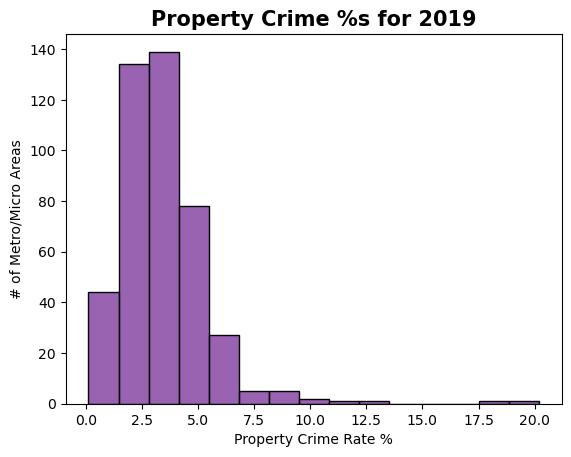

In [14]:
# Plot property crime as a % of population

pcrime_hist = sns.histplot(data=p_crime_df, x='Property_Crime_PCT', 
                          bins=15, color=purple, multiple='dodge')
pcrime_hist.set_title('Property Crime %s for 2019', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
pcrime_hist.set(xlabel='Property Crime Rate %', ylabel='# of Metro/Micro Areas')

plt.show()

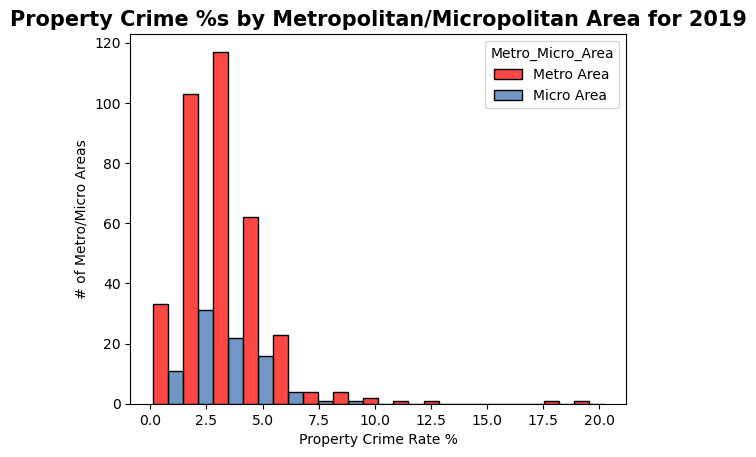

In [15]:
# Plot property crime as a % of population broken out by Metropolitan/Micropolitan Area

pcrime_histc = sns.histplot(data=p_crime_df, x='Property_Crime_PCT', 
                          bins=15, hue='Metro_Micro_Area', multiple='dodge')
pcrime_histc.set_title('Property Crime %s by Metropolitan/Micropolitan Area for 2019', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
pcrime_histc.set(xlabel='Property Crime Rate %', ylabel='# of Metro/Micro Areas')

plt.show()

In [16]:
# Look at the last 10 records to identify the outliers by name

p_crime_df = p_crime_df.sort_values('Property_Crime_PCT',ascending = False)
print('\nTop 10 of Property Crime Areas')
print(p_crime_df[['Metropolitan_Short','Metro_Micro_Area',
                  'Property_Crime_PCT']].head(10))
print('\nBottom 10 of Property Crime Areas')
print(p_crime_df[['Metropolitan_Short','Metro_Micro_Area',
                  'Property_Crime_PCT']].tail(10))


Top 10 of Property Crime Areas
                                Metropolitan_Short Metro_Micro_Area  \
391                                    Hammond, LA       Metro Area   
272                                  Brunswick, GA       Metro Area   
228                            Anniston-Oxford, AL       Metro Area   
251                                    Beckley, WV       Metro Area   
15   Myrtle Beach-Conway-North Myrtle Beach, SC-NC       Metro Area   
368                                    Gadsden, AL       Metro Area   
221                                 Alexandria, LA       Metro Area   
261                         Bloomsburg-Berwick, PA       Metro Area   
191                    Weirton-Steubenville, WV-OH       Metro Area   
55                                  Pine Bluff, AR       Metro Area   

     Property_Crime_PCT  
391               20.21  
272               18.84  
228               12.50  
251               11.14  
15                10.56  
368                9.89  
221 

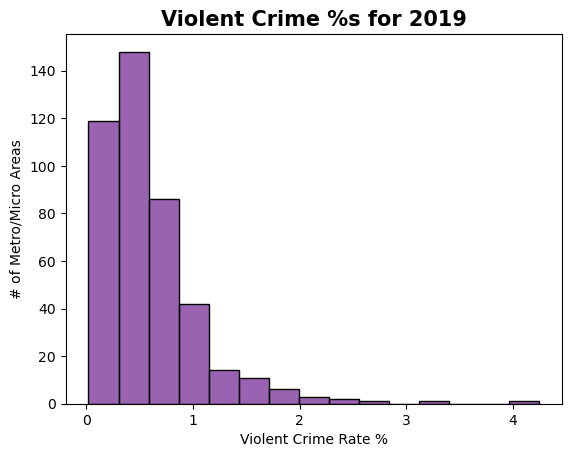

In [17]:
# Plot violent crime as a % of population

vcrime_hist = sns.histplot(data=v_crime_df, x='Violent_Crime_PCT', 
                          bins=15, color=purple, multiple='dodge')
vcrime_hist.set_title('Violent Crime %s for 2019', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
vcrime_hist.set(xlabel='Violent Crime Rate %', ylabel='# of Metro/Micro Areas')

plt.show()

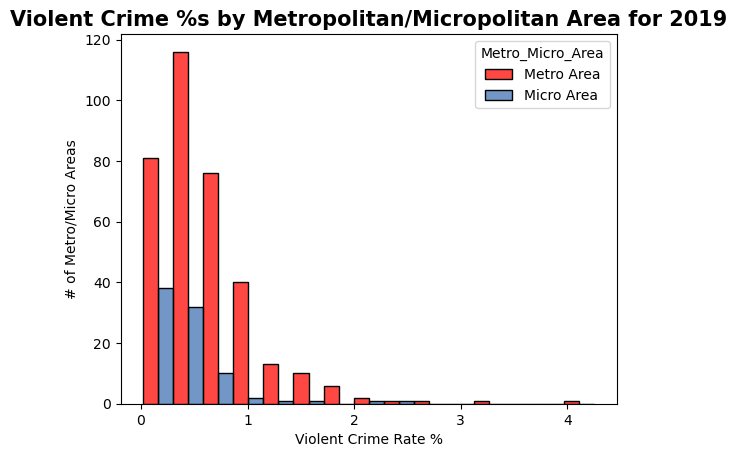

In [18]:
# Plot violent crime as a % of population broken out by Metropolitan/Micropolitan Area

vcrime_histc = sns.histplot(data=v_crime_df, x='Violent_Crime_PCT', 
                          bins=15, hue='Metro_Micro_Area', multiple='dodge')
vcrime_histc.set_title('Violent Crime %s by Metropolitan/Micropolitan Area for 2019', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
vcrime_histc.set(xlabel='Violent Crime Rate %', ylabel='# of Metro/Micro Areas')

plt.show()

In [19]:
# Look at the last 10 records to identify the outliers by name

v_crime_df = v_crime_df.sort_values('Violent_Crime_PCT',ascending = False)
print('\nTop 10 of Violent Crime Areaa')
print(v_crime_df[['Metropolitan_Short','Metro_Micro_Area',
                  'Violent_Crime_PCT']].head(10))
print('\nBottom 10 of Violent Crime Areas')
print(v_crime_df[['Metropolitan_Short','Metro_Micro_Area',
                  'Violent_Crime_PCT']].tail(10))


Top 10 of Violent Crime Areaa
              Metropolitan_Short Metro_Micro_Area  Violent_Crime_PCT
391                  Hammond, LA       Metro Area               4.25
228          Anniston-Oxford, AL       Metro Area               3.25
353               Farmington, NM       Metro Area               2.58
39                 Opelousas, LA       Micro Area               2.53
272                Brunswick, GA       Metro Area               2.50
55                Pine Bluff, AR       Metro Area               2.19
330  Detroit-Warren-Dearborn, MI       Metro Area               2.06
371                   Gallup, NM       Micro Area               2.03
495            Memphis, TN-MS-AR       Metro Area               1.97
101             St. Louis, MO-IL       Metro Area               1.97

Bottom 10 of Violent Crime Areas
                              Metropolitan_Short Metro_Micro_Area  \
471                                   London, KY       Micro Area   
397                                   

### High School Graduation Rates

Look for the outliers in the high school graduation rates and 
which Metropolitan/Micropolitan area they belong to.

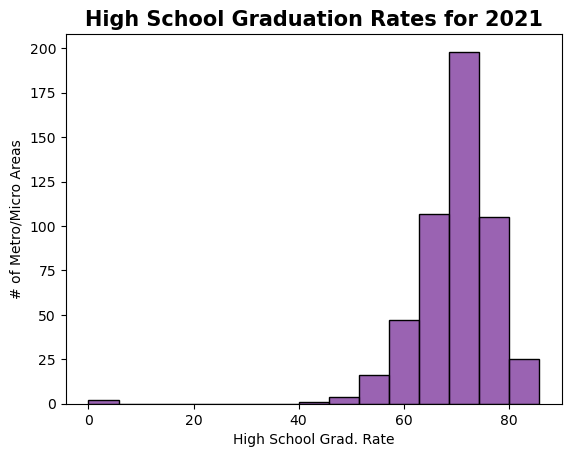

In [20]:
# Plot the high school graduation rates

hsgrad_hist = sns.histplot(data=MSK_df, x='High_School_Grad_Rate', 
                          bins=15, color=purple, multiple='dodge')
hsgrad_hist.set_title('High School Graduation Rates for 2021', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
hsgrad_hist.set(xlabel='High School Grad. Rate', ylabel='# of Metro/Micro Areas')

plt.show()

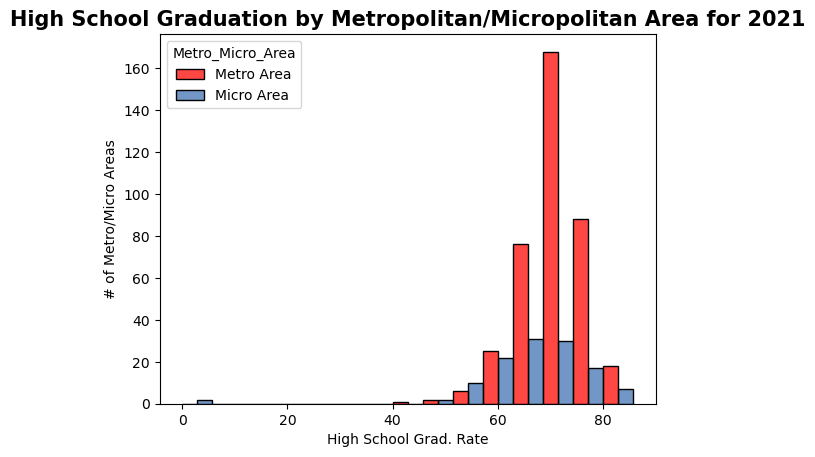

In [21]:
# Plot high school graduation rates broken out by Metropolitan/Micropolitan Area

hsgrad_hist = sns.histplot(data=MSK_df, x='High_School_Grad_Rate', 
                          bins=15, hue='Metro_Micro_Area', multiple='dodge')
hsgrad_hist.set_title('High School Graduation by Metropolitan/Micropolitan Area for 2021', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
hsgrad_hist.set(xlabel='High School Grad. Rate', ylabel='# of Metro/Micro Areas')

plt.show()

In [22]:
# Look at the First & last 10 records to identify the outliers by name

MSK_df = MSK_df.sort_values('High_School_Grad_Rate',ascending = False)
print('\nTop 10 of High School Graduation Rates')
print(MSK_df[['Metropolitan_Short','Metro_Micro_Area',
              'High_School_Grad_Rate']].head(10))
print('\nBottom 10 of High School Graduation Rates')
print(MSK_df[['Metropolitan_Short','Metro_Micro_Area',
              'High_School_Grad_Rate']].tail(10))


Top 10 of High School Graduation Rates
              Metropolitan_Short Metro_Micro_Area  High_School_Grad_Rate
356                  Findlay, OH       Micro Area                   85.8
361              Fond du Lac, WI       Metro Area                   84.1
135              Sioux Falls, SD       Metro Area                   84.0
446    La Crosse-Onalaska, WI-MN       Metro Area                   83.8
470                 Logan, UT-ID       Metro Area                   83.2
334                  Dubuque, IA       Metro Area                   83.0
188  Watertown-Fort Atkinson, WI       Micro Area                   82.2
350                 Fargo, ND-MN       Metro Area                   82.0
504                    Minot, ND       Micro Area                   81.9
439                 Key West, FL       Micro Area                   81.8

Bottom 10 of High School Graduation Rates
         Metropolitan_Short Metro_Micro_Area  High_School_Grad_Rate
406   Homosassa Springs, FL       Metro Area  

### Employment Percentage

Look for the outliers in employment percentage of the population 
and which Metropolitan/Micropolitan area they belong to. 

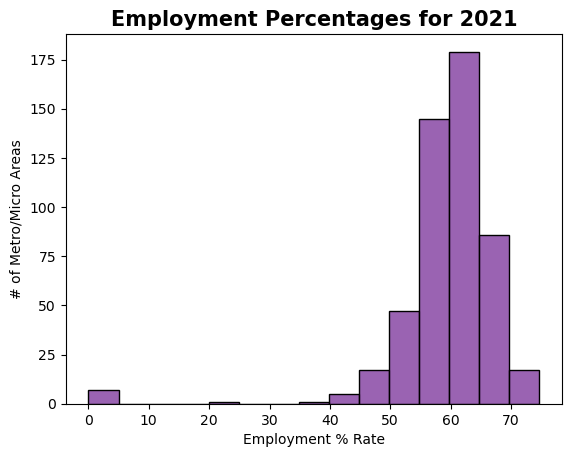

In [23]:
# Plot the overall employment percentage.

employ_hist = sns.histplot(data=MSK_df, x='Employment_PCT', 
                          bins=15, color=purple, multiple='dodge')
employ_hist.set_title('Employment Percentages for 2021', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
employ_hist.set(xlabel='Employment % Rate', ylabel='# of Metro/Micro Areas')

plt.show()

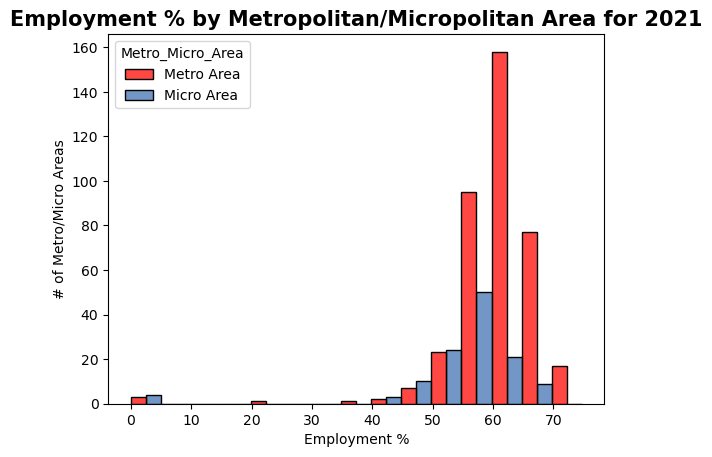

In [24]:
# Plot employment % rates broken out by Metropolitan/Micropolitan Area

employ_hist = sns.histplot(data=MSK_df, x='Employment_PCT',  
                    bins=15, hue='Metro_Micro_Area', hue_order=hue_order, 
                           multiple='dodge')
employ_hist.set_title('Employment % by Metropolitan/Micropolitan Area for 2021', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
employ_hist.set(xlabel='Employment %', ylabel='# of Metro/Micro Areas')

plt.show()

In [25]:
# Look at the First & last 10 records to identify the outliers by name

MSK_df = MSK_df.sort_values('Employment_PCT',ascending = False)
print('\nTop 10 of Employment Percentage Rates')
print(MSK_df[['Metropolitan_Short','Metro_Micro_Area',
              'Employment_PCT']].head(10))
print('\nBottom 10 of Employment Percentage Rates')
print(MSK_df[['Metropolitan_Short','Metro_Micro_Area',
              'Employment_PCT']].tail(10))


Top 10 of Employment Percentage Rates
                   Metropolitan_Short Metro_Micro_Area  Employment_PCT
135                   Sioux Falls, SD       Metro Area            74.7
350                      Fargo, ND-MN       Metro Area            74.1
501                       Midland, TX       Metro Area            72.9
98                      St. Cloud, MN       Metro Area            71.5
328        Denver-Aurora-Lakewood, CO       Metro Area            71.5
416                     Iowa City, IA       Metro Area            71.4
70                     Provo-Orem, UT       Metro Area            71.3
106                Salt Lake City, UT       Metro Area            71.2
468                       Lincoln, NE       Metro Area            71.1
240  Austin-Round Rock-Georgetown, TX       Metro Area            70.9

Bottom 10 of Employment Percentage Rates
        Metropolitan_Short Metro_Micro_Area  Employment_PCT
72         Punta Gorda, FL       Metro Area            42.1
406  Homosassa Spr

### Average Age

Look for the outliers of average age based on population and 
which Metropolitan/Micropolitan area they belong to.

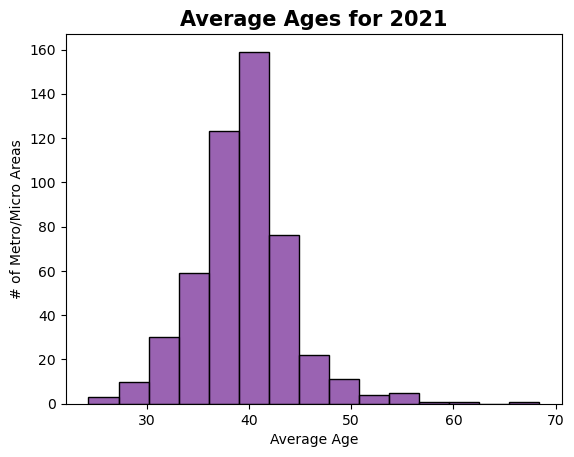

In [26]:
# Plot the overall average ages.

age_hist = sns.histplot(data=MSK_df, x='Median_Age', 
                          bins=15, color=purple, multiple='dodge')
age_hist.set_title('Average Ages for 2021', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
age_hist.set(xlabel='Average Age', ylabel='# of Metro/Micro Areas')

plt.show()

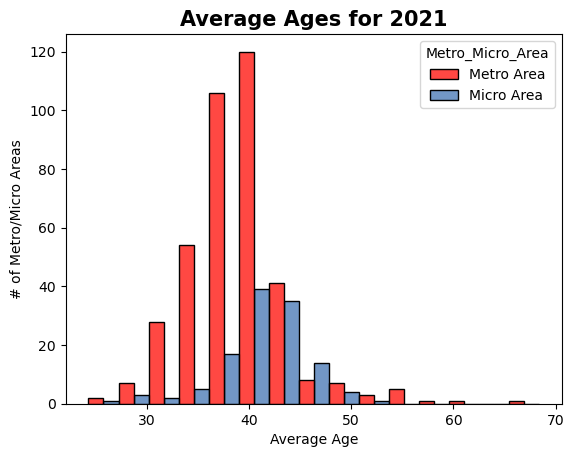

In [27]:
# Plot the average ages broken out by Metropolitan/Micropolitan Area

age_hist = sns.histplot(data=MSK_df, x='Median_Age', 
                          bins=15, hue='Metro_Micro_Area', multiple='dodge')
age_hist.set_title('Average Ages for 2021', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
age_hist.set(xlabel='Average Age', ylabel='# of Metro/Micro Areas')

plt.show()

In [28]:
# Look at the First & last 10 records to identify the outliers by name

MSK_df = MSK_df.sort_values('Median_Age',ascending = False)
print('\nTop 10 locations of the Average Age')
print(MSK_df[['Metropolitan_Short','Metro_Micro_Area',
              'Median_Age']].head(10))
print('\nBottom 10 locations of the Average Age')
print(MSK_df[['Metropolitan_Short','Metro_Micro_Area',
              'Median_Age']].tail(10))


Top 10 locations of the Average Age
                    Metropolitan_Short Metro_Micro_Area  Median_Age
159                   The Villages, FL       Metro Area        68.4
72                     Punta Gorda, FL       Metro Area        60.4
406              Homosassa Springs, FL       Metro Area        57.8
68        Prescott Valley-Prescott, AZ       Metro Area        55.3
122           Sebastian-Vero Beach, FL       Metro Area        55.1
245                Barnstable Town, MA       Metro Area        54.6
123              Sebring-Avon Park, FL       Metro Area        54.4
26   North Port-Sarasota-Bradenton, FL       Metro Area        53.9
452       Lake Havasu City-Kingman, AZ       Metro Area        53.4
17             Naples-Marco Island, FL       Metro Area        52.7

Bottom 10 locations of the Average Age
            Metropolitan_Short Metro_Micro_Area  Median_Age
303  College Station-Bryan, TX       Metro Area        29.7
403             Hinesville, GA       Metro Area        

### Homes with Internet

Look for the outliers of homes with internet and 
which Metropolitan/Micropolitan area they belong to.

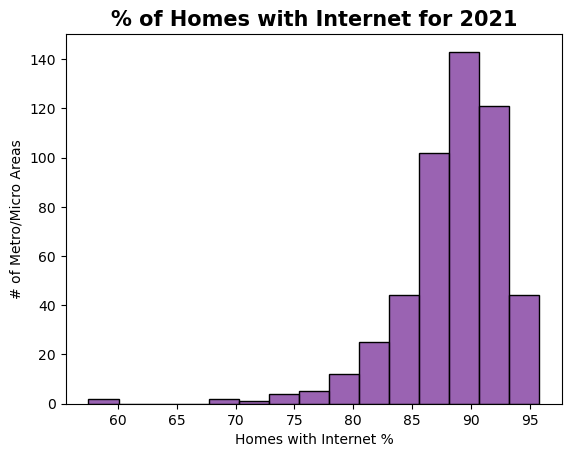

In [29]:
# Plot the Internet Availability in Homes

inet_hist = sns.histplot(data=MSK_df, x='Homes_With_Internet_PCT', 
                          bins=15, color=purple, multiple='dodge')
inet_hist.set_title('% of Homes with Internet for 2021', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
inet_hist.set(xlabel='Homes with Internet %', ylabel='# of Metro/Micro Areas')

plt.show()

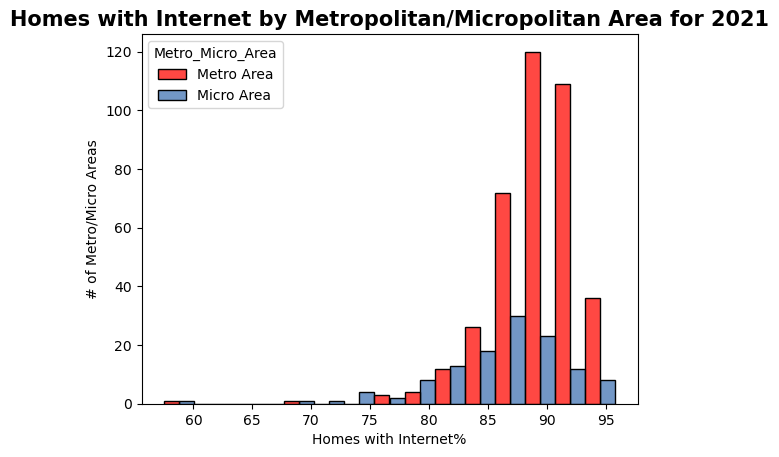

In [30]:
# Plot Internet Availability in Homes broken out by Metropolitan/Micropolitan Area

inet_hist = sns.histplot(data=MSK_df, x='Homes_With_Internet_PCT', 
                          bins=15, hue='Metro_Micro_Area', multiple='dodge')
inet_hist.set_title('Homes with Internet by Metropolitan/Micropolitan Area for 2021', 
                      fontdict={'size': 15, 'weight': 'bold', 'color': 'black'})
inet_hist.set(xlabel='Homes with Internet%', ylabel='# of Metro/Micro Areas')

plt.show()

In [31]:
# Look at the First & last 10 records to identify the outliers by name

MSK_df = MSK_df.sort_values('Homes_With_Internet_PCT',ascending = False)
print('\nTop 10 of Homes with Internet Rates')
print(MSK_df[['Metropolitan_Short','Metro_Micro_Area',
              'Homes_With_Internet_PCT']].head(10))
print('\nBottom 10 of Homes with Internet Rates')
print(MSK_df[['Metropolitan_Short','Metro_Micro_Area',
              'Homes_With_Internet_PCT']].tail(10))


Top 10 of Homes with Internet Rates
                        Metropolitan_Short Metro_Micro_Area  \
112     San Jose-Sunnyvale-Santa Clara, CA       Metro Area   
265                            Boulder, CO       Metro Area   
304                   Colorado Springs, CO       Metro Area   
37              Olympia-Lacey-Tumwater, WA       Metro Area   
269  Bremerton-Silverdale-Port Orchard, WA       Metro Area   
121            Seattle-Tacoma-Bellevue, WA       Metro Area   
397                              Heber, UT       Micro Area   
109     San Diego-Chula Vista-Carlsbad, CA       Metro Area   
29                          Oak Harbor, WA       Micro Area   
436                              Kapaa, HI       Micro Area   

     Homes_With_Internet_PCT  
112                     95.8  
265                     95.5  
304                     95.5  
37                      95.2  
269                     95.2  
121                     95.2  
397                     95.1  
109                  

## Step 6 - Write the records to excel

In [32]:
# Shuffle the MSK records to remove the last sort.  Write the 
# first and last 10 records to the Milestone #2 Moving Starter 
# Kit to an excel file

# Re-sort the records
MSK_df = MSK_df.sample(frac = 1)

MSK_head_df = MSK_df.head(10)
MSK_tail_df = MSK_df.tail(10)
MSK_recs = pd.concat([MSK_head_df,MSK_tail_df])

MSK_recs.to_excel("C:/DSC540_Data/MSK Milestone 2.xlsx", sheet_name='MSK') 